#Task - 1

In [262]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [263]:
dataset = pd.read_csv('/content/train.csv')
dataset.head()

,ID,date,Item Id,Item Name,ad_spend,anarix_id,units,unit_price
0,2022-04-12_B09KDTS4DC,2022-04-12,B09KDTS4DC,"NapQueen Elizabeth 8"" Gel Memory Foam Mattress...",NaN,NAPQUEEN,0.0,0.0
1,2022-04-12_B09MR2MLZH,2022-04-12,B09MR2MLZH,NapQueen 12 Inch Bamboo Charcoal Queen Size Me...,NaN,NAPQUEEN,0.0,0.0
2,2022-04-12_B09KSYL73R,2022-04-12,B09KSYL73R,"NapQueen Elsa 8"" Innerspring Mattress, Twin XL",NaN,NAPQUEEN,0.0,0.0
3,2022-04-12_B09KT5HMNY,2022-04-12,B09KT5HMNY,"NapQueen Elsa 6"" Innerspring Mattress, Twin",NaN,NAPQUEEN,0.0,0.0
4,2022-04-12_B09KTF8ZDQ,2022-04-12,B09KTF8ZDQ,"NapQueen Elsa 6"" Innerspring Mattress, Twin XL",NaN,NAPQUEEN,0.0,0.0


In [264]:
dataset.shape

(101490, 8)

In [265]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101490 entries, 0 to 101489
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          101490 non-null  object 
 1   date        101490 non-null  object 
 2   Item Id     101488 non-null  object 
 3   Item Name   99658 non-null   object 
 4   ad_spend    77303 non-null   float64
 5   anarix_id   101490 non-null  object 
 6   units       83592 non-null   float64
 7   unit_price  101490 non-null  float64
dtypes: float64(3), object(5)
memory usage: 6.2+ MB


In [266]:
dataset.describe()

,ad_spend,units,unit_price
count,77303.000000,83592.000000,101490.000000
mean,110.771470,10.284381,106.750922
std,529.303777,68.945915,425.704733
min,0.000000,-173.000000,-8232.000000
25%,0.000000,0.000000,0.000000
50%,4.230000,1.000000,0.000000
75%,44.310000,5.000000,0.000000
max,47934.990000,9004.000000,21557.390000


In [267]:
dataset['date'] = pd.to_datetime(dataset['date'])

#Pre - Processing

In [268]:
dataset.isnull().sum()

,0
ID,0
date,0
Item Id,2
Item Name,1832
ad_spend,24187
anarix_id,0
units,17898
unit_price,0


In [269]:
dataset = dataset.dropna(subset=['Item Id'])
#Since the count is low

In [270]:
dataset['Item Id'] = dataset['Item Id'].fillna('Not Availiable')
dataset['Item Name'] = dataset['Item Name'].fillna('Not Availiable')
#placeholder technique - to avoid data loss

In [271]:
dataset['units'] = dataset.groupby('Item Id')['units'].transform(lambda x: x.fillna(x.median()))
#Median imputation

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [272]:
dataset['ad_spend'] = dataset.groupby('Item Id')['ad_spend'].transform(lambda x: x.fillna(x.median()))
#Median imputation

In [273]:
dataset['units'] = pd.to_numeric(dataset['units'], errors='coerce')
dataset = dataset[dataset['units'] >= 0]
#To remove negative value

In [274]:
dataset['unit_price'] = pd.to_numeric(dataset['unit_price'], errors='coerce')
dataset = dataset[dataset['unit_price'] >= 0]
#To remove negative value

In [275]:
dataset.isnull().sum()

,0
ID,0
date,0
Item Id,0
Item Name,0
ad_spend,0
anarix_id,0
units,0
unit_price,0


#Exploratory data Analysis

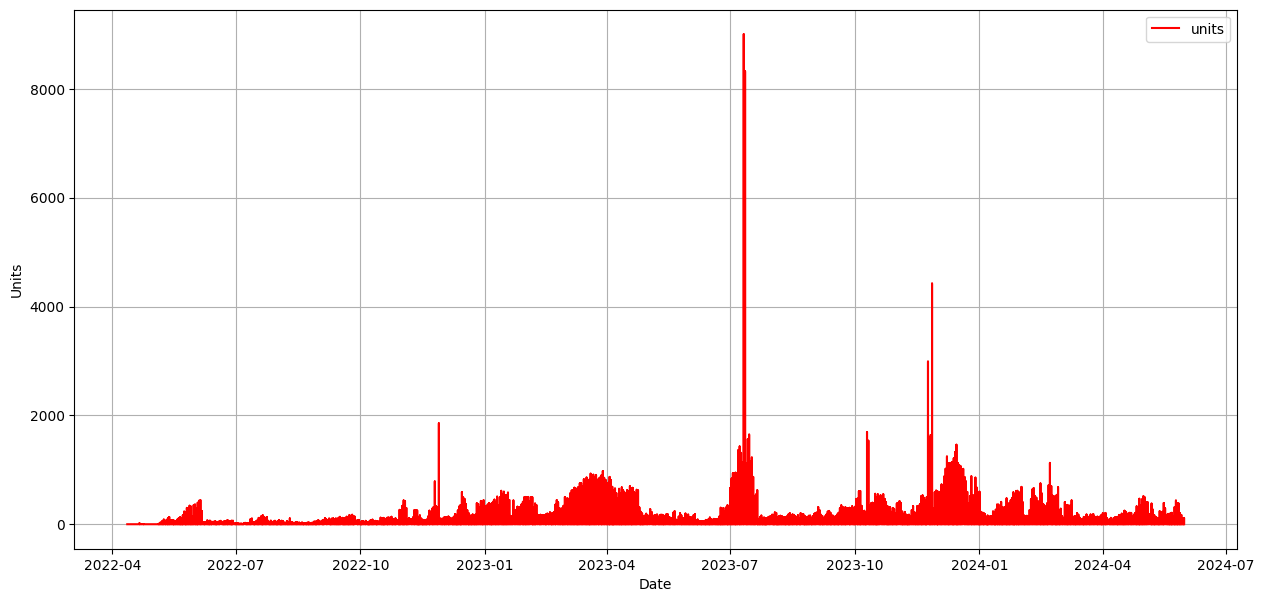

In [229]:
plt.figure(figsize=(15, 7))
plt.plot(dataset['date'], dataset['units'], label='units', color = 'red')
plt.xlabel('Date')
plt.ylabel('Units')
plt.grid(True)
plt.legend()
plt.show()

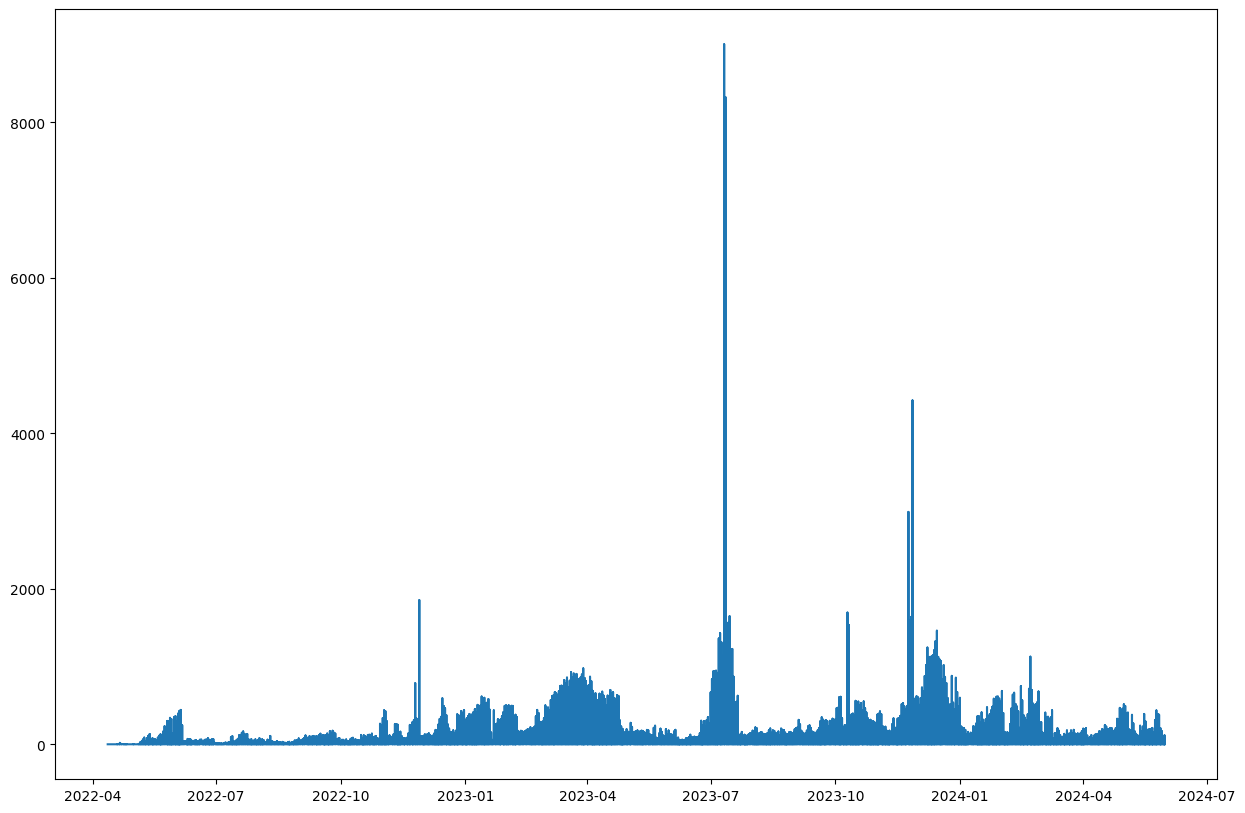

In [230]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset['units'], model='additive',period = 7)
plt.figure(figsize=(15,10))

plt.plot(dataset['date'], dataset['units'], label='Original')

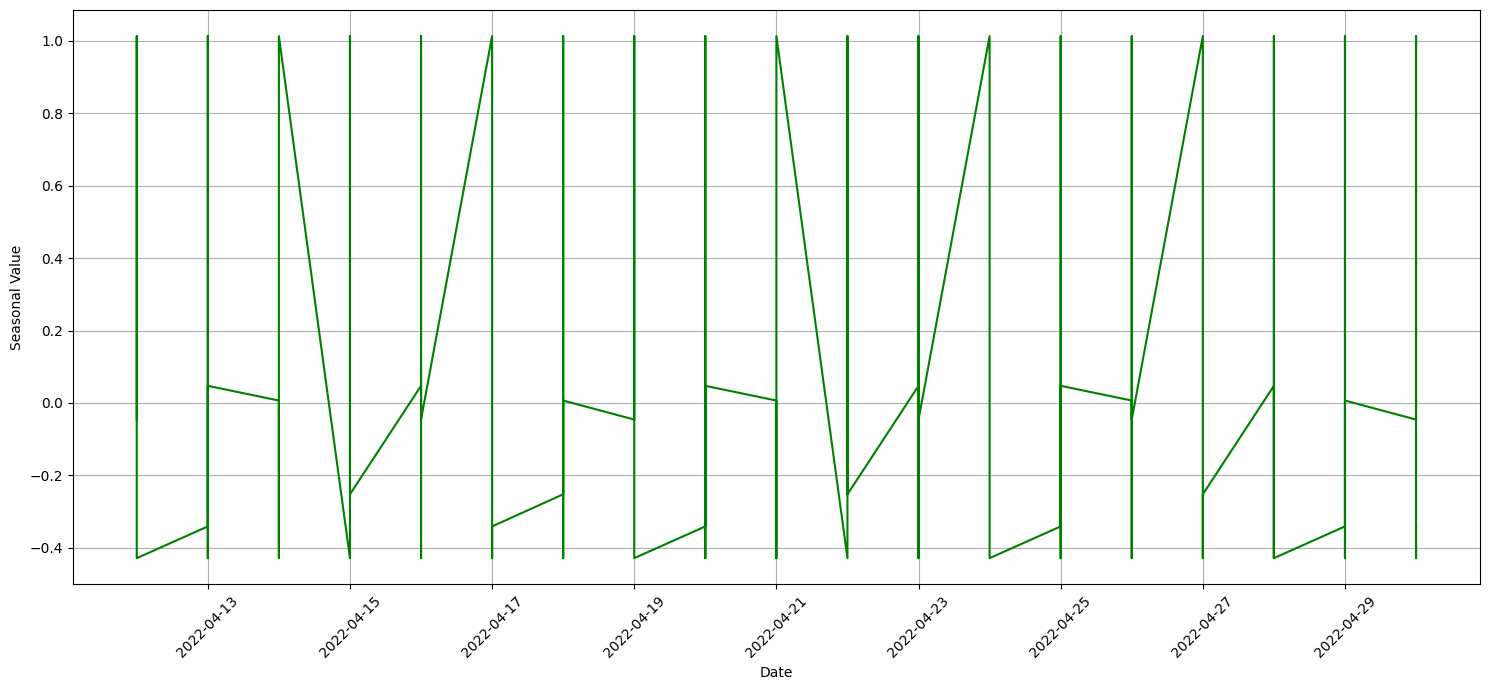

In [233]:
subset_data = dataset[(dataset['date'] >= '2022-04-01') & (dataset['date'] < '2022-05-01')]
subset_seasonal = decomposition.seasonal[subset_data.index]
plt.figure(figsize=(15,7))
plt.plot(subset_data['date'], subset_seasonal, color='green')
plt.xlabel('Date')
plt.ylabel('Seasonal Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

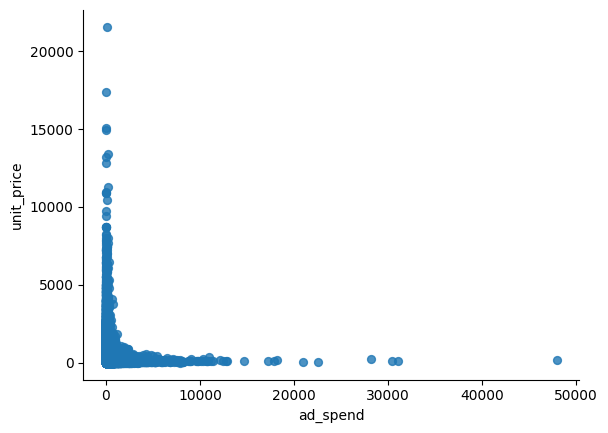

In [235]:
dataset.plot(kind='scatter', x='ad_spend', y='unit_price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

#Stationarity Test

The Augmented Dickey-Fuller test is a formal statistical test for stationarity.

H0: The null hypothesis of the test is that the time series is not stationary.
H1: The alternative hypothesis is that the time series is stationary

In [236]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(dataset['units'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -34.804809
p-value: 0.000000




ADF Statistic is highly negative.

p-value: A value of 0.00000 is below 0.05. So, we reject the null hypothesis of the ADF test, suggesting that the time series is stationary.

A stationary series often leads to better model performance because the statistical properties (mean, variance) of the series remain constant over time.

#Modelling

In [276]:
dataset = dataset.rename(columns={'date': 'ds', 'units': 'y', 'ad_spend': 'additional_feature'})

In [285]:
prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
prophet_model.add_regressor('additional_feature')
prophet_model.fit(dataset)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8rota0u_/rtye_c3h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8rota0u_/a89k2l_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79115', 'data', 'file=/tmp/tmp8rota0u_/rtye_c3h.json', 'init=/tmp/tmp8rota0u_/a89k2l_q.json', 'output', 'file=/tmp/tmp8rota0u_/prophet_model83eqo_og/prophet_model-20240802130737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:07:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:07:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [278]:
test = pd.read_csv('/content/test.csv')
test.head()

,ID,date,Item Id,Item Name,ad_spend,anarix_id,unit_price
0,2024-07-01_B09KDR64LT,2024-07-01,B09KDR64LT,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
1,2024-07-01_B09KDTS4DC,2024-07-01,B09KDTS4DC,"NapQueen Elizabeth 8"" Gel Memory Foam Mattress...",NaN,NAPQUEEN,0.0
2,2024-07-01_B09KDTHJ6V,2024-07-01,B09KDTHJ6V,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
3,2024-07-01_B09KDQ2BWY,2024-07-01,B09KDQ2BWY,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
4,2024-07-01_B09KDYY3SB,2024-07-01,B09KDYY3SB,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",101.72,NAPQUEEN,1094.5


In [279]:
test['date'] = pd.to_datetime(test['date'])

#Preprocessing Test Data

In [280]:
test.isnull().sum()

,0
ID,0
date,0
Item Id,0
Item Name,344
ad_spend,1451
anarix_id,0
unit_price,0


In [281]:
test['Item Name'] = test['Item Name'].fillna('Not Availiable')

In [282]:
test['ad_spend'] = test.groupby('Item Id')['ad_spend'].transform(lambda x: x.fillna(x.median()))

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local

#Predictions

In [286]:
test['date'] = pd.to_datetime(test['ID'].str.split('_').str[0])
test['ds'] = test['date']
future = test[['ds', 'ad_spend']]
forecast = prophet_model.predict(future)
predictions = test[['ID']].copy()
predictions['TARGET'] = forecast['yhat']
predictions.to_csv('predictions.csv', index=False)

#Task 2

In [291]:
dataset = dataset.rename(columns={'date': 'ds', 'units': 'y'})

In [292]:
from prophet import Prophet
prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
prophet_model.fit(dataset)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8rota0u_/upj2hz6x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8rota0u_/h5eh5ztn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43348', 'data', 'file=/tmp/tmp8rota0u_/upj2hz6x.json', 'init=/tmp/tmp8rota0u_/h5eh5ztn.json', 'output', 'file=/tmp/tmp8rota0u_/prophet_model2awe8k8v/prophet_model-20240802131731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:17:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:17:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [293]:
test['date'] = pd.to_datetime(test['ID'].str.split('_').str[0])
test['ds'] = test['date']
future = test[['ds']]
forecast = prophet_model.predict(future)
predictions = test[['ID']].copy()
predictions['TARGET'] = forecast['yhat']
predictions.to_csv('predictions task - 2.csv', index=False)